In [1]:
%pylab inline
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
from jax.scipy.ndimage import map_coordinates
from constant import * 
import warnings
from jax import jit, partial
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


### Value iteration of renting a house

$$V_t(w_t,n_{t-1}, s_t) = max_{\{c_t, h_t, b_t, k_t\}}\{ u(c_t, h_t) + \beta E[P_t V_{t+1}(w_{t+1}, n_{t},s_{t+1}) + (1-P_t) u_B(w_{t+1}, n_{t})]\}$$
Subject to:    
$$y_t^{AT} + w_t = c_t + P_t^r h_t + b_t + k_t$$
$$ w_{t+1} = (1+r_t^f) b_t + (1+r_{t+1}^m) k_t $$    

Shape of the state: $$(20 \times 20 \times 27 \times 2)$$
Shape of the actions: $$(30 \times 30)$$

In [2]:
nX = Xs.shape[0]
Xs.shape

(10800, 3)

In [3]:
nA = As.shape[0]
As.shape

(400, 2)

In [4]:
X = jnp.repeat(Xs, nA, axis = 0)
A = jnp.tile(As, (nX,1))

In [5]:
#(17280000, 2)
A.shape

(4320000, 2)

In [6]:
X.shape

(4320000, 3)

In [7]:
#Define the earning function, which applies for both employment, 27 states
@partial(jit, static_argnums=(0,)) 
def y(t, x):
    if t <= T_R:
        return detEarning[t] * (1+gGDP[jnp.array(x[:,2], dtype = jnp.int16)])
    else:
        return detEarning[t] * jnp.ones(X.shape[0])
    
#Earning after tax and fixed by transaction in and out from 401k account 
@partial(jit, static_argnums=(0,)) 
def yAT(t,x):
    yt = y(t, x)  
    if t <= T_R:
        # yi portion of the income will be put into the 401k 
        return (1-tau_L)*(yt * (1-yi))
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        return (1-tau_R)*yt + x[:,1]/Dt[t]
    
#Define the evolution of the amount in 401k account 
@partial(jit, static_argnums=(0,)) 
def gn(t, x, r):
    if t <= T_R:
        # if the person is employed, then yi portion of his income goes into 401k 
        n_cur = x[:,1] + y(t, x) * yi
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        n_cur = x[:,1]  - x[:,1]/Dt[t]
        # the 401 grow as the same rate as the stock 
    return (1+r)*n_cur

In [8]:
#Define the utility function
@jit
def u(c):
    return (jnp.power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth
@jit
def uB(tb):
    return B*u(tb)

#Reward function for renting
@jit
def u_rent(a):
    '''
    Input:
        action a: c, b, k, h = a
    Output:
        reward value: the length of return should be equal to the length of a
    '''
    c = a[:,0]
    h = a[:,3]
    C = jnp.power(c, alpha) * jnp.power(h, 1-alpha)
    return u(C)

@partial(jit, static_argnums=(2,)) 
def transition_to_rent(x,a,t):
    '''
        imput: a is np array constains all possible actions 
        output: from x = w_t to x = w_{t+1}
        x = [w, n, s]
    '''
    s = jnp.array(x[:,1], dtype = jnp.int16)
    # actions taken 
    b = a[:,1]
    k = a[:,2]
    w_next = ((1+r_b[s])*b + jnp.outer(k,(1+r_k)).T).T.flatten()
    s_next = jnp.tile(jnp.arange(nS),nA*nX)
    # growth rate of 401k is an average between stock and bond
    n_next = gn(t, X.repeat(nS,axis = 0), (r_b[s].repeat(nS) + r_k[s_next])/2)
    prob_next = Ps[s].flatten()
    return w_next, n_next, s_next, prob_next
    
# used to calculate dot product
@jit
def dotProduct(p_next, uBTB, t):
    return (p_next*uBTB).reshape((p_next.shape[0]//(nS), (nS))).sum(axis = 1)

# define approximation of fit
@jit
def fit(v, w_next, n_next, s_next):
    return map_coordinates(v.reshape(dim),jnp.vstack((w_next/scale,n_next/scale, s_next)), order = 1, mode = 'nearest')

In [9]:
%%time
for t in range(T_max-1,T_min, -1):
    print(t)
    # x = [w,s], a = [c,b,k,h]
    income = yAT(t,X)
    budget1 = income + X[:,0]
#     h = budget1*A[:,0]/pr
#     budget2 = budget1*(1-A[:,0])
#     c = budget2*A[:,1]
#     budget3 = budget2*(1-A[:,1])
#     k = budget3*A[:,2]
#     b = budget3*(1-A[:,2])
    h = budget1*A[:,0]*0.3/pr
    c = budget1*A[:,0]*0.7
    budget2 = budget1*(1-A[:,0])
    k = budget2*A[:,1]
    b = budget2*(1-A[:,1])
    actions = jnp.column_stack((c,b,k,h))
    # if right before the terminal state 
    if t == T_max - 1:
        w_next, n_next, s_next, prob_next = transition_to_rent(X,actions,t)
        Q = u_rent(actions) + beta * dotProduct(prob_next, uB(w_next+n_next),t)
        V = Q.reshape(nX,nA).max(axis = 1)
        cbkh = actions[:nA][Q.reshape(nX,nA).argmax(axis = 1)]
    else:
        w_next, n_next, s_next, prob_next = transition_to_rent(X,actions,t)
        Q = u_rent(actions) + beta * dotProduct(prob_next, Pa[t] * 
                                                fit(V, w_next, n_next, s_next)
                                                + (1-Pa[t]) * uB(w_next+n_next), t)
        V = Q.reshape(nX,nA).max(axis = 1)
        cbkh = actions[:nA][Q.reshape(nX,nA).argmax(axis = 1)]
        
    Vgrid[:,:,:,t] = V.reshape(dim)
    cgrid[:,:,:,t] = cbkh[:,0].reshape(dim)
    bgrid[:,:,:,t] = cbkh[:,1].reshape(dim)
    kgrid[:,:,:,t] = cbkh[:,2].reshape(dim)
    hgrid[:,:,:,t] = cbkh[:,3].reshape(dim)

59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
CPU times: user 19.2 s, sys: 16.1 s, total: 35.3 s
Wall time: 41.3 s


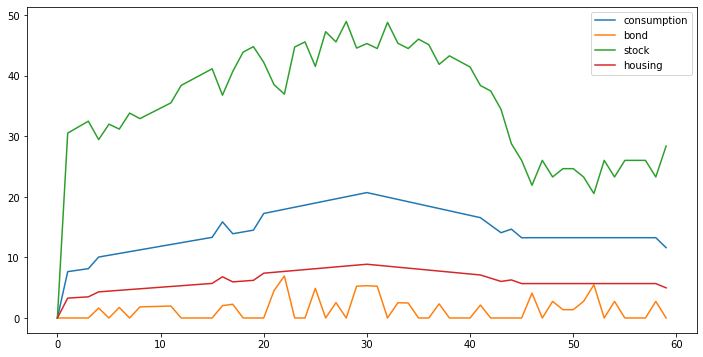

In [10]:
# plot consumption against time 
wealthLevel = 5
retirement = 5
econState = 5
plt.figure(figsize = [12,6])
plt.plot(cgrid[wealthLevel,retirement,econState,:], label = "consumption")
plt.plot(bgrid[wealthLevel,retirement,econState,:], label = "bond")
plt.plot(kgrid[wealthLevel,retirement,econState,:], label = "stock")
plt.plot(hgrid[wealthLevel,retirement,econState,:]*pr, label = "housing")
legend()

In [11]:
np.save('cgrid',cgrid)
np.save('bgrid',bgrid)
np.save('kgrid',kgrid)
np.save('hgrid',hgrid)